# Introduction

In [1]:
# Import required packages
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

Open `lotka_volterra_data.h5` file on notebook

In [2]:
with h5py.File('lotka_volterra_data.h5', 'r') as f:
    # Access the full dataset
    trajectories = f['trajectories'][:]
    time_points = f['time'][:]

    # Access a single trajectory
    system_id = 0 # First system

Checikng shape of the dataset, we expect trajectories to be of size $(1000 \times 100 \times 2)$, and time_points of size $(100 \times 1)$

In [3]:
print('Time points shape:',time_points.shape)
print('')
print('Trajectory shape (pray/predator):',trajectories.shape)

Time points shape: (100,)

Trajectory shape (pray/predator): (1000, 100, 2)


In [4]:

num_systems, num_time_steps, num_variables = trajectories.shape
# Create a DataFrame
df_traj = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems), num_time_steps),  # Repeats 0-999, each 100 times
    "time_step": np.repeat(time_points[np.arange(num_time_steps)], num_systems),    # Cycles 0-99 for each system
    "prey": trajectories[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories[:, :, 1].flatten()  # Flatten predator values
})


In [5]:
df_traj # Visualising data in dataframe format

,system_id,time_step,prey,predator
0,0,0.0,0.949917,1.040624
1,0,0.0,0.740551,0.779542
2,0,0.0,0.682246,0.564390
3,0,0.0,0.716674,0.407644
4,0,0.0,0.824511,0.300283
...,...,...,...,...
99995,999,200.0,0.901549,0.579420
99996,999,200.0,0.957527,0.539055
99997,999,200.0,1.036460,0.515615
99998,999,200.0,1.129212,0.510619


In [6]:
time_step = df_traj['time_step'].to_numpy()

print(time_step[4925])

8.080808080808081


# Part 2 (a)

Grouping prey and predator into arrays to determine the maximum value for scaling procedure.

In [7]:
prey_array = df_traj['prey'].to_numpy() # Converting to numpy array
predator_array = df_traj['predator'].to_numpy()

### 2.10 Scaling Dataset `lotka_volterra_data.h5`

As we will see in the `Table` presented below, in the original dataset we have laues that vary significantly. To standardize the numeric range, we are going to use [quantiles]( https://en.wikipedia.org/wiki/Quantile). A quantile is a value that divides a dataset into equal-sized intervals, indicating the data points below which a given percentage if observations fall. From the project instructions it is adviced to apply a simple scaling:
$$
x_t' = \frac{x_t}{\alpha}
$$
where $\alpha$ should be chosen based on the distribution of the dataset `lotka_volterra_data.h5`.

In our particular case we want most of our dataset to be in range $[0,10]$. This is coded in the [`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py) file, which appropriate docstrings.



#### `numpy.quantile()`

For scaling our dataset we want to use [`numpy.quantile()`](https://numpy.org/doc/2.1/reference/generated/numpy.quantile.html). The `numpy.quantile()` function calculates the quantiles of a given NumPy array. Quantiles are cut points that devide the data into intercals with equal probability. Thus `numpy.quantile()`can be used to scale our dataset dynamically, without having to worry about choosing the appropriate value for $\alpha$.

All of this is implemented in the function `scaling_operator`, which also <b>rounds</b> each datapoint using `numpy.round()`, this is set to 3 decimal places.

In [8]:
# Import class Preprocessor from src/preprocessor.py
from src.preprocessor import Preprocessor

# Set scaling_operator to function 
scaling_operator = Preprocessor.scaling_operator

Scaling data

In [9]:
trajectories_scaled, scaling_factor = scaling_operator(trajectories, 0.9, 10)
print('Scaling factor:', scaling_factor)

Scaling factor: 0.25283724


Collecting scaled data into `pandas.DataFrame` format, in particular, we want to construct a $100000\times 4$ table, (number of rows $= 1000 \times 100$). With four colums, of which three are `time_step`, `prey` and `predator`, but with an additional one `system_id` (this separates the $1000$ different systems), which will be later used to convert our timeseries data into string format.

In [10]:
num_systems_scaled, num_time_steps_scaled, num_variables_scaled = trajectories_scaled.shape

# Create a DataFrame
df_traj_scaled = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems_scaled), num_time_steps_scaled),  # Repeats 0-999, each 100 times
    "time_step": np.repeat(time_points[np.arange(num_time_steps_scaled)], num_systems_scaled),  # Cycles 0-200 (array.shape = (100,)) for each system
    "prey": trajectories_scaled[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories_scaled[:, :, 1].flatten()  # Flatten predator values
})

Visualising `df_traj_scaled`.

In [11]:
df_traj_scaled

,system_id,time_step,prey,predator
0,0,0.0,3.757,4.116
1,0,0.0,2.929,3.083
2,0,0.0,2.698,2.232
3,0,0.0,2.835,1.612
4,0,0.0,3.261,1.188
...,...,...,...,...
99995,999,200.0,3.566,2.292
99996,999,200.0,3.787,2.132
99997,999,200.0,4.099,2.039
99998,999,200.0,4.466,2.020


Converting `prey` and `predator` columns into array using [`pandas.DataFrame.to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html)

In [12]:
prey_array_scaled = df_traj_scaled['prey'].to_numpy() # Converting to numpy array
predator_array_scaled = df_traj_scaled['predator'].to_numpy()

Defining a function that calculates the percentage of values in an array that fall outside a given range. (This seem tedious, as we set a value for quantile in the function `scaling_operator`, e.g. $q = 0.9$, means that only $10%$ of the values will be out of our custom range. But this will be used to measure what percentage of datapoints in the original dataset is outside a specific range.)

In [13]:
def scaling_measure(arr, min_val, max_val):
    
    """
    Calculates the percentage of values in an array that fall outside a given range.

    Parameters:
    -----------
    arr : array-like
        The input numerical data.
    min_val : float
        The minimum acceptable value.
    max_val : float
        The maximum acceptable value.

    Returns:
    --------
    str
        The percentage of values outside the range, formatted as a string.
    """

    # Count values about the max range
    outside_count = np.sum((arr < min_val)|(arr > max_val))

    # Calculating the pergentage of values outside max range
    percentage_outside = (outside_count/arr.size)*100

    return f'{percentage_outside:.2f}%'

Collecting scaling information into a Table using `pandas.DataFrame`.

In [14]:
min_val = 0
max_val = 1
Table_1 = pd.DataFrame({

    'Pray': [max(prey_array), np.mean(prey_array), min(prey_array), scaling_measure(prey_array, min_val, max_val)],
    'Pray after scaling': [max(prey_array_scaled), np.mean(prey_array_scaled), min(prey_array_scaled), scaling_measure(prey_array_scaled, min_val, max_val)],
    'Predator': [max(predator_array), np.mean(predator_array), min(predator_array), scaling_measure(predator_array, min_val, max_val)],
    'Predator after scaling': [max(predator_array_scaled), np.mean(predator_array_scaled), min(predator_array_scaled), scaling_measure(predator_array_scaled, min_val, max_val)],
    
})
Table_1.index = ["Maximim Value", "Mean Value", "Minimum Value", f"Values outside the range {min_val}-{max_val}"] # Adding index for each row

 From the table below, we can observe, scaling was successful. The reason why we want to test how many data points are outside the range $[0,1]$, is due to the fact that a lot of data points in the original dataset (pre-scaling) are very small, many of order $10^{-3}$ (and smaller order $10^{-4}$), which may affect the tokenisation process.

In [15]:
Table_1

,Pray,Pray after scaling,Predator,Predator after scaling
Maximim Value,13.740113,54.344002,4.76849,18.860001
Mean Value,1.698114,6.71623,0.569606,2.252858
Minimum Value,0.002077,0.008,0.000037,0.0
Values outside the range 0-1,63.11%,93.82%,12.21%,77.31%


Looking at the last row, we can see that we have a major improvement for both `prey` and `predator` categories, the percentage of values outside the range $[0,1]$ has increased in `prey` by ~ $30\%$ and `predator` by ~ $65\%$. Thus, scaling was successful. Now we can proceed with the next step, i.e. converting the scaled dataset to strings, for compatibility with [Qwen2.5]( https://github.com/QwenLM/Qwen2.5).

### 2.11 Loading Qwen2.5

Below a short demonstration on how to use `load_qwen()` from `src.qwen`.

In [17]:
from src.qwen import load_qwen # Import load_qwen
model, tokenizer = load_qwen() # set model = model and tokeinzer = tokenizer

Trying with examples provided at the end of project instructions, see [LLMTIME Preprocessing Scheme](https://github.com/MatteoMancini01/M2_Cw/blob/main/instructions/main.pdf).

In [18]:
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
print('')
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])

[16, 13, 17, 18]

[16, 659, 220, 17, 220, 18]


Trying to tokenise $[0.25,1.50;0.27,1.47;0.31,1.42]$

In [19]:
print(tokenizer("0.25,1.50;0.27,1.47;0.31,1.42", return_tensors='pt')["input_ids"].tolist()[0])

[15, 13, 17, 20, 11, 16, 13, 20, 15, 26, 15, 13, 17, 22, 11, 16, 13, 19, 22, 26, 15, 13, 18, 16, 11, 16, 13, 19, 17]


Example of how `load_qwen()` works!

In [20]:
text = 'Hello, world' # Define input text
input_ids = tokenizer(text, return_tensors='pt').input_ids # Tokenize text 
output = model.generate(input_ids, max_length = 50) # Generate output

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


From the above code line 3 `output`, the variable `max_length` determines how many more words will the model predict when inputing text, e.g. `text = Hello, world`, as we can see from the below output.

In [21]:
output

tensor([[ 9707,    11,  1879,     0, 20166,   311,   279,  1156,   304,   264,
          4013,   315,  7999,   389,   279,  3840,   323,  7674,   315,   279,
          1809,   315, 32719,    13,   758,   419,  1736,    11,   582,  4700,
           387,  3330,   518,   279,  6238,   323,  4124,  4401,   315,   279,
          1809,  5086,   624, 88242,   572, 35492,   553,   279, 13833, 81504]])

From the above tensor we recognise that the first 3 tokens are related to our text, the rest of the tokens is predicted text determined from the model, as we will see below when decoding `output`.

In [22]:
print(tokenizer.decode(output[0], skip_special_tokens=True)) # Decoding output

Hello, world! Welcome to the first in a series of posts on the history and culture of the game of chess. In this post, we’ll be looking at the origin and early development of the game itself.
Chess was invented by the ancient Egyptians


### 2.12 Converting Scaled Dataset into Strings

We now have seen how tokenisation for text works! There is a small issue, Qwen2.5 is only designed to convert text, i.e. strings in Python, to tokens, while our dataset is a timeseries composed of 2 variables prey and predator over a time series of size 100, this is repated for a 1000 samples. Thus, before we proceed with tokenisation, we require to convert the time series data into sets of strings. To do so we are going to define a fucntion `array_to_string(data)`, and a function to convert string to array `sring_to_array(formatted_string)` (both functions are in [preprocessor.py](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py)).

⚠ Note: The function `array_to_string` is specifically designed for the dataset `lotka_volterra_data.h5`, in particular after converting `trajectories` into a `panda.DataFrame` format, with columns `system_id` (labeling each system from 0 to 999), columns `prey` and `predator`, each  displaying 100 data points for every `system_id`.

In [23]:
from src.preprocessor import Preprocessor

array_to_string = Preprocessor.array_to_string # Importing array_to_string(data) to convert timeseries to string
string_to_array = Preprocessor.string_to_array # Importing string_to_array(formatted_string) to convert strings back to arrays

traject_scaled_string = array_to_string(df_traj_scaled) # Converting df_traj_scaled into string format

Checking result post-conversion

In [24]:
print(traject_scaled_string) # Print output

system_id
0      3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.61...
1      3.842,3.977;4.266,3.25;4.987,2.715;6.019,2.346...
2      4.245,4.401;3.378,3.56;3.038,2.801;3.04,2.187;...
3      4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.28...
4      3.276,3.167;3.533,2.247;4.089,1.611;4.943,1.17...
                             ...                        
995    3.918,4.625;2.139,3.254;1.521,2.104;1.327,1.32...
996    3.595,4.653;2.249,3.797;1.681,2.896;1.484,2.15...
997    4.465,4.433;4.055,4.03;3.9,3.615;3.981,3.237;4...
998    4.476,4.017;3.167,3.167;2.564,2.341;2.362,1.68...
999    4.035,4.489;3.028,4.1;2.481,3.453;2.277,2.794;...
Length: 1000, dtype: object


We also want to test the function `string_to_array`, this is done below for the first `system_id` string data format, i.e. `system_id` $ = 0$.

In [25]:
print(string_to_array(traject_scaled_string[0]))

[[ 3.757  4.116]
 [ 2.929  3.083]
 [ 2.698  2.232]
 [ 2.835  1.612]
 [ 3.261  1.188]
 [ 3.973  0.909]
 [ 4.995  0.736]
 [ 6.35   0.642]
 [ 8.033  0.611]
 [ 9.978  0.64 ]
 [12.027  0.741]
 [13.915  0.938]
 [15.283  1.271]
 [15.732  1.785]
 [14.933  2.492]
 [12.876  3.282]
 [10.089  3.882]
 [ 7.451  4.015]
 [ 5.574  3.666]
 [ 4.52   3.066]
 [ 4.08   2.448]
 [ 4.068  1.929]
 [ 4.385  1.536]
 [ 4.991  1.259]
 [ 5.869  1.081]
 [ 7.002  0.986]
 [ 8.344  0.963]
 [ 9.801  1.013]
 [11.212  1.145]
 [12.356  1.373]
 [12.979  1.715]
 [12.864  2.165]
 [11.941  2.672]
 [10.379  3.118]
 [ 8.59   3.351]
 [ 7.014  3.296]
 [ 5.897  3.004]
 [ 5.265  2.6  ]
 [ 5.044  2.193]
 [ 5.154  1.845]
 [ 5.539  1.577]
 [ 6.165  1.389]
 [ 6.997  1.277]
 [ 7.985  1.235]
 [ 9.047  1.263]
 [10.065  1.363]
 [10.892  1.539]
 [11.366  1.792]
 [11.36   2.108]
 [10.829  2.451]
 [ 9.87   2.75 ]
 [ 8.698  2.927]
 [ 7.569  2.934]
 [ 6.673  2.781]
 [ 6.095  2.527]
 [ 5.834  2.238]
 [ 5.856  1.969]
 [ 6.119  1.748]
 [ 6.586  1.58

As we can observe from the above output, we successfully converted string back to array.

### 2.13 Tokenisation 

We provided few basic examples on how to use `load_qwen()` in section 2.11, with some text and numbers (string form). We now want to proceed and tokenise our data, to achieve this, we designed a function for our particular needs that uses `model, tokenizer = load_qwen()`.


In [26]:
from src.qwen import tokenize_time_series


In [27]:
tokenised_data = tokenize_time_series(traject_scaled_string)

Visualising data before tokenisation:

In [28]:
traject_scaled_string

system_id
0      3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.61...
1      3.842,3.977;4.266,3.25;4.987,2.715;6.019,2.346...
2      4.245,4.401;3.378,3.56;3.038,2.801;3.04,2.187;...
3      4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.28...
4      3.276,3.167;3.533,2.247;4.089,1.611;4.943,1.17...
                             ...                        
995    3.918,4.625;2.139,3.254;1.521,2.104;1.327,1.32...
996    3.595,4.653;2.249,3.797;1.681,2.896;1.484,2.15...
997    4.465,4.433;4.055,4.03;3.9,3.615;3.981,3.237;4...
998    4.476,4.017;3.167,3.167;2.564,2.341;2.362,1.68...
999    4.035,4.489;3.028,4.1;2.481,3.453;2.277,2.794;...
Length: 1000, dtype: object

After tokenisation:

In [29]:
tokenised_data

system_id
0      [input_ids, attention_mask]
1      [input_ids, attention_mask]
2      [input_ids, attention_mask]
3      [input_ids, attention_mask]
4      [input_ids, attention_mask]
                  ...             
995    [input_ids, attention_mask]
996    [input_ids, attention_mask]
997    [input_ids, attention_mask]
998    [input_ids, attention_mask]
999    [input_ids, attention_mask]
Length: 1000, dtype: object

Clsoer look at two examples:

In [30]:
# Print tokenised output for the first system
print('Two examples of tokens from tokenised_data:')
print('')
print('Preprocessed data:')
print(traject_scaled_string[3])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[3]["input_ids"].squeeze().tolist())  # Tokenised tensor
print('Length of the above token:',len(tokenised_data.iloc[3]["input_ids"].squeeze().tolist()))  # Tokenised tensor
print('')
print('')
print('Preprocessed data:')
print(traject_scaled_string[990])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[990]["input_ids"].squeeze().tolist())
print('Length of the above token:',len(tokenised_data.iloc[990]["input_ids"].squeeze().tolist()))


Two examples of tokens from tokenised_data:

Preprocessed data:
4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.281;1.064,2.682;0.985,2.167;1.001,1.747;1.097,1.415;1.276,1.159;1.55,0.967;1.943,0.829;2.482,0.737;3.2,0.687;4.123,0.678;5.257,0.716;6.562,0.815;7.924,0.998;9.13,1.307;9.86,1.792;9.749,2.494;8.564,3.374;6.523,4.207;4.348,4.651;2.719,4.538;1.766,4.031;1.271,3.387;1.035,2.764;0.945,2.226;0.951,1.787;1.036,1.44;1.201,1.173;1.456,0.973;1.825,0.827;2.337,0.728;3.024,0.67;3.917,0.652;5.029,0.68;6.335,0.763;7.739,0.925;9.045,1.203;9.947,1.649;10.062,2.316;9.091,3.192;7.12,4.099;4.814,4.678;2.985,4.677;1.89,4.211;1.314,3.563;1.034,2.913;0.918,2.344;0.904,1.876;0.969,1.505;1.11,1.218;1.338,1.001;1.671,0.841;2.137,0.73;2.772,0.661;3.609,0.631;4.669,0.644;5.946,0.706;7.369,0.838;8.777,1.073;9.892,1.46;10.333,2.058;9.727,2.895;7.978,3.859;5.6,4.616;3.489,4.82;2.134,4.464;1.414,3.824;1.061,3.142;0.904,2.528;0.861,2.019;0.9,1.612;1.013,1.295;1.205,1.054;1.493,0.875;1.904,0.747;2.469,0.663;3.22

Summary of <b>Part 2 (a)</b>:

- Load the predator-prey dataset from the `lotka_volterra_data.h5` file.
- Applied the LLMTIME preprocessing scheme, this includes:
    - Scale the numaric values using the fucntion ` scaling_operator` (in file `preprocessor.py`).
    - Round the values to a fixed number of decimal places (we have used 3 d.p.).
    - Converted the sequences into formatted strings using:
        - Commas to separate variables at each timestep.
        - Semicolons to separate different timesteps.
        - Collection of every system.
- Tokenised the processed sequences using the Qwen2.5 tokeniser.  

# Part 2 (b)

This section aims to evaluate the performance of the untrained Qwen2.5-Instruct model's forecasting ability on the tokenised dataset, i.e. `tokenised_data` from Part 2(a) (previus section).

Due to lack of computational power and limited number of FLOPS available for this project, we are not going to invest much time to this part. To save time and FLOPS we are only going to consider a subset of the dataset, $10\%$ of our original dataset, i.e. 100 systems out of the available 1000.

Approach to the problem:

1. Select the first 100 system from our dataset.
2. Select the first 50 data points from each of the 100 selected systems
3. Tokenise the selected subset.
4. Use `model.generate` to predict and decode the remaining 50 pairs of datapoints.
5. Convert back to tameseries data.
6. Visualise: select one of the predictions and plot them against actual data.
7. Measure error predicted vs real data, for each of the 100 selected systems.

After completing all the above steps, we can analyse and comment on the results.


1. <b>Select the first 100 system from our dataset.</b>
2. <b>Select the first 50 data points from each of the 100 selected systems</b>

The easiest approach is to work with `df_traj_scaled` (`pandas.DataFrame` format). Easy to select 100 system and cut off the last half of the data-points (prey, predator).

In [31]:
df_traj_scaled

,system_id,time_step,prey,predator
0,0,0.0,3.757,4.116
1,0,0.0,2.929,3.083
2,0,0.0,2.698,2.232
3,0,0.0,2.835,1.612
4,0,0.0,3.261,1.188
...,...,...,...,...
99995,999,200.0,3.566,2.292
99996,999,200.0,3.787,2.132
99997,999,200.0,4.099,2.039
99998,999,200.0,4.466,2.020


In [32]:
# Step 1: Keep only the first 100 system_ids
df_filtered = df_traj_scaled[df_traj_scaled['system_id'] < 100]  

# Step 2: Remove last 50 rows for each system_id
df_sub_traj_scaled = df_filtered.groupby('system_id').apply(lambda x: x.iloc[:-50]).reset_index(drop=True)

/tmp/ipykernel_98889/2856005867.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sub_traj_scaled = df_filtered.groupby('system_id').apply(lambda x: x.iloc[:-50]).reset_index(drop=True)


In [33]:
df_sub_traj_scaled

,system_id,time_step,prey,predator
0,0,0.000000,3.757,4.116
1,0,0.000000,2.929,3.083
2,0,0.000000,2.698,2.232
3,0,0.000000,2.835,1.612
4,0,0.000000,3.261,1.188
...,...,...,...,...
4995,99,18.181818,10.700,0.208
4996,99,18.181818,11.849,0.223
4997,99,18.181818,12.991,0.253
4998,99,18.181818,14.071,0.302


3. <b>Tokenise the selected subset.</b>

Recall Part 2(a): before tokenisation we had to convert data into string, we used the function `array_to_string` from `preprocessor.py`. Ultimately we tokenised the converted dataset with the function `tokenize_time_series` from `qwen.py`. Here we are going to repeat the same process.

In [34]:
from src.preprocessor import Preprocessor

# Converting subset of Timeseries data into str  
array_to_string = Preprocessor.array_to_string

str_sub_traj_scaled = array_to_string(df_sub_traj_scaled)

print(str_sub_traj_scaled)

system_id
0     3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.61...
1     3.842,3.977;4.266,3.25;4.987,2.715;6.019,2.346...
2     4.245,4.401;3.378,3.56;3.038,2.801;3.04,2.187;...
3     4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.28...
4     3.276,3.167;3.533,2.247;4.089,1.611;4.943,1.17...
                            ...                        
95    4.234,3.744;2.521,3.788;1.537,3.401;1.033,2.84...
96    3.475,3.839;3.859,2.855;4.615,2.16;5.79,1.687;...
97    4.49,3.363;2.452,3.76;1.269,3.499;0.715,2.929;...
98    4.154,3.333;3.803,3.131;3.619,2.883;3.602,2.63...
99    3.52,4.021;2.318,2.788;1.856,1.846;1.713,1.202...
Length: 100, dtype: object


In [35]:
# Tokenisation of str_sub_traj_scaled

# Import required funstion
from src.qwen import tokenize_time_series

# Tokenising sub-dataset
tok_sub_traj_scaled = tokenize_time_series(str_sub_traj_scaled)

# Checking result
print(tok_sub_traj_scaled)

system_id
0     [input_ids, attention_mask]
1     [input_ids, attention_mask]
2     [input_ids, attention_mask]
3     [input_ids, attention_mask]
4     [input_ids, attention_mask]
                 ...             
95    [input_ids, attention_mask]
96    [input_ids, attention_mask]
97    [input_ids, attention_mask]
98    [input_ids, attention_mask]
99    [input_ids, attention_mask]
Length: 100, dtype: object


Below a basic function to determone the max lenght of a tokenised sequence.

In [36]:
def max_sequence_length(tokenized_data):
    max_length = max(entry["input_ids"].shape[1] for entry in tokenized_data)

    return f'Max Sequence Length: {max_length}'

Comparing full dataset vs sub-dataset max sequence length

In [37]:
print('Full dataset:')
print(max_sequence_length(tokenised_data))
print('')
print('Sub-dataset:')
print(max_sequence_length(tok_sub_traj_scaled))

Full dataset:
Max Sequence Length: 1281

Sub-dataset:
Max Sequence Length: 633


As expected, from the above output the largest sequence of each tokenised dataset has dropped by ~ $\frac{1}{2}$.

4. <b>Use `model.generate` to predict and decode the remaining 50 pairs of datapoints.</b>

We need to know the maximum lenght for each sequence in the tokenised sub-datased.

In [ ]:
max_lengths = []  

for i in range(100):
    input_ids = tok_sub_traj_scaled[i]["input_ids"]  # Extract the input IDs
    max_length = input_ids.shape[1]  # Get the length of the sequence
    max_lengths.append(max_length)  # Append only the integer value
print('List of sequence lengths:')
print(max_lengths)


List of sequence lengths:
[609, 613, 608, 590, 631, 586, 613, 596, 583, 586, 592, 607, 588, 585, 595, 589, 596, 604, 594, 605, 585, 588, 589, 594, 605, 588, 588, 589, 595, 600, 596, 632, 591, 592, 605, 600, 598, 604, 633, 609, 593, 591, 592, 603, 605, 599, 606, 582, 613, 590, 593, 583, 624, 589, 614, 591, 590, 611, 589, 590, 598, 592, 620, 623, 600, 614, 606, 589, 583, 601, 587, 604, 594, 588, 590, 604, 597, 596, 610, 605, 588, 583, 617, 587, 601, 597, 630, 588, 589, 595, 593, 604, 601, 586, 616, 588, 625, 587, 588, 609]


Collecting `input_ids` and `attention_mask` into `input_ids_list` and `attention_mask_list` respectivelly. 

In [137]:
input_ids_list = [tok_sub_traj_scaled[i]["input_ids"] for i in range(100)]
attention_masks_list = [tok_sub_traj_scaled[i]["attention_mask"] for i in range(100)]

Below we are using `model.generate` to predict the next 50 pairs (prey, predator), using the intrained Qwen2.5-Instruct model's forecasting ability on our tokenised data subset.

In [ ]:
output_list = []
range_model = 100

for i in range(range_model):
    output = model.generate(input_ids_list[i], # Sequence, numerical tokens
                            attention_mask = attention_masks_list[i], # 
                            max_length = 2*max_lengths[i], # Maximum length of generated output
                            num_return_sequences=1, # Number of prediction to return per input
                            do_sample=True, # Enables sampling (i.e. introduces randomness)
                            temperature=0.7, # Controls randomness of predictions
                            top_p=0.8, # Nucleus sampling (filters low-probability tokens)
                            top_k=20 # Limits the number of token options at each step
                            )
    output_list.append(output)

Below we are decoding the predicted output and collecting it into `decoded_output_list`.

In [ ]:
decoded_output_list = []

for i in range(range_model):
    decoded_output = tokenizer.decode(output_list[i][0], skip_special_tokens=True)
    decoded_output_list.append(decoded_output)

5. Converting strings output in `decoded_output_list` back into timeseries data.

In [237]:
string_to_array_list = []

for i in range(10):
    decoded_to_number = string_to_array(decoded_output_list[i])
    string_to_array_list.append(decoded_to_number)


6. Determining the mean square error.

Since our input for `model.generate` where the first 50 pair point (prey, predator), when calculating the mean square error (MSE), we can remove the first 50 datapoints from our prediced output, as model provides input tokens $+$ predicted tokens. 

In [238]:
# Removing the first 50 input tokens and true values

predicted_output = []
true_values = []
for i in range(len(string_to_array_list)):
    sub_output = string_to_array_list[i]
    sub_output_min_50 = sub_output[50:]
    true_v = trajectories_scaled[i]
    true_v_min_50 = true_v[50:]
    predicted_output.append(sub_output_min_50)
    true_values.append(true_v_min_50)


Now another issue occurs, some of the predictions have more or less than 50 pair points, henche when determing the MSE we need to be careful in terms of dimensions. Furthermore we are going to use `mean_quare_error` from `sklearn.matrices` to compute the MSE between predicted and true values.

In [217]:
# Importing MSE
from sklearn.metrics import mean_absolute_error

MSE_values = []


for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values.append([mse_prey, mse_predator])


# Collecting everything into a dataframe
# Create a DataFrame
df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "MSE for prey": np.array(MSE_values)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values)[:, 1]  # Flatten predator values
})
df_MSE_values

,system_id,MSE for prey,MSE for predator
0,0,1.564640,0.981360
1,1,18.046447,0.315979
2,2,1.992460,0.984040
3,3,3.129102,1.805429
4,4,0.031854,0.009021
5,5,0.557180,0.267000
6,6,1.002820,1.173840
7,7,0.376940,1.234100
8,8,0.448980,0.269080
9,9,2.004918,1.135694


7. Visualising one of the 100 predicted systems vs its true values

In [ ]:
traj_0 = string_to_array(traject_scaled_string[5])
dec_0 = string_to_array_list[5]
print(dec_0.shape)
print(traj_0.shape)

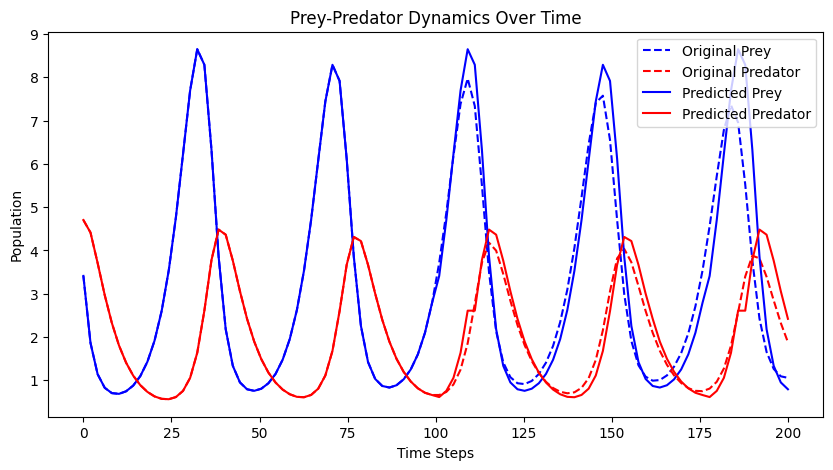

In [ ]:
# Ensure `decoded_to_number` is trimmed to match `traj_0`
min_length = min(len(traj_0), len(dec_0))

# Trim both arrays to the same length
time_step = np.linspace(0, 200, min_length)  # Adjust time range
prey_values = traj_0[:min_length, 0]  # Trim original prey
predator_values = traj_0[:min_length, 1]  # Trim original predator

predict_prey = dec_0[:min_length, 0]  # Trim predicted prey
predict_predator = dec_0[:min_length, 1]  # Trim predicted predator

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(time_step, prey_values, label="Original Prey", color="blue", linestyle="dashed")
plt.plot(time_step, predator_values, label="Original Predator", color="red", linestyle="dashed")

plt.plot(time_step, predict_prey, label="Predicted Prey", color="blue")
plt.plot(time_step, predict_predator, label="Predicted Predator", color="red")

# Labels and Title
plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title("Prey-Predator Dynamics Over Time")
plt.legend()

# Show the plot
plt.show()


Prepare input data